# Optimal Execution Strategy with Price Limiter (Chap 7.2)

This file implements the optimal acquisition strategy when a  trader has a maximum price that they are willing to pay for the asset. The theory is covered in Chapter 7.2 of

Algorithmic and High-Frequency Trading (c) Cartea, Jaimungal, & Penalva, 2015 Cambridge University Press

https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance/dp/1107091144/ref=cm_cr_arp_d_product_top?ie=UTF8

The agent's aims to minimize the performance criterion
$$\mathbb{E}\left[\int_0^\tau (S_u+k\,\nu_u)\,\nu_u\,du + y_\tau (S_\tau + \alpha y_\tau) + \phi \int_0^\tau y_u^2\,du\right]$$
where the stopping time
$$
\tau = \min(T;\; \min\{t: S_t \le \overline{S}\}; ),
$$
i.e. it is the minimum of (i) the trading horizon $T$, (ii) the first time the asset hits the upper barrier $\overline{S}$, (iii) the time at which the agent acquires all their shares.

Here $y_t$ denotes the inventory remaining to acquire and $S_t$ is the asset price which is assumed to satisfy the SDE:
$$
S_t = S_0 + \int_0^t b \nu_u du + \sigma\,W_t
$$
and $W_t$ is a Brownian motion

In [1]:
# Importing Packges
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import importnb
with __import__('importnb').Notebook(): 
    import PriceLimitSim_helpers
from mpl_toolkits import mplot3d
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(20)  # Setting random seed
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 4),
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize': 15,
         'ytick.labelsize': 15}
pylab.rcParams.update(params)

Initialize a number of constants used in the analysis

In [2]:
lw = 0.75  # Line width in plots
Nsims = int(10000)  # Number of simulations

# time grid
T = int(1) # Expiry
Ndt = int(6.5*60)  # Number of time increments
dt = T/Ndt  # Time change increment

N = 1  # Target Inventory
sigma = 0.1  # volatilty (recall this is an artihmetic model)

k = 1*10**(-4)  # Temporary Market Impact
b = 0  # permanent price impact factor

phi = 1 * 10**(-3)  # Running penalty coefficient
alpha = 100 * k  # Barrier and terminal penalty coefficient
real_alpha = alpha  # Penalty coefficient for simulations

F0 = 20  # Starting Fundamental Price
Fmax = F0 + sigma   # Upper Limite of Fundamental Price

# the price grid 
Fmin = F0 - 5*sigma  # Lower Limit of Fundamental Price
NdF = 1000  # Step of price change
dF = (Fmax - Fmin)/NdF  # Price increments

# for plotting results
idxfig =[2, 5, 7]  # Index of paths to be plotted
lower_cutoff = Nsims*0.02  # Lower bound for presenting frequency in simulation 

## Solve the Hamilton-Jacobi-Bellman Equation (7.4)

When the permanent impact parameter is zero, we can solve for the dependence in inventory explicitly, and the optimal strategy $\nu^*$ is given by 
$$
\nu_t^* = \frac{1}{k}\,y_t^*\,h(t,S_t^*)
$$
where the asteriks are the processes evaluated along the optimal strategy, and the function $h(t,S)$ satsifies the terminal and boundary value PDE
\begin{align}
\left( \partial_t + \tfrac{1}{2}\sigma^2 \partial_{SS} \right) h(t,S) - \tfrac{1}{k} h(t,s) + \phi &= 0, \\
h(T,S) &= \alpha, \quad S\le\overline{S} \\
h(t,\overline{S}) &= \alpha, \quad t\le T
\end{align}

In [3]:
h, Fgrid, t = PriceLimitSim_helpers.solve_pde_hjb(Fmin, Fmax, int(NdF), alpha, phi, k, sigma, T, int(Ndt))

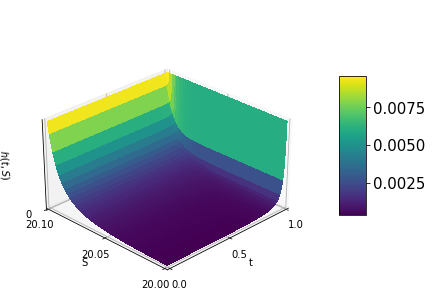

In [4]:
PriceLimitSim_helpers.plot_stategy(h, t, Fgrid, F0, T, Fmin, Fmax)

## Strategy Simulation
Next, we look at how the strategy performs along simulated paths and compare it with the Almgren-Chris strategy.

In [5]:
# Initializing variables for simulation base on computed strategy
X = np.full([Nsims, Ndt+1], np.nan)  # Cost matrix of Strategy
Q = np.full([Nsims, Ndt+1], np.nan)  # Inventory matrix

F = np.full([Nsims, Ndt+1], np.nan)  # Fundamental Price matrix
S = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix

nu = np.full([Nsims, Ndt+1], np.nan)  # Rate of Trading matrix

I = np.full([Nsims, 1], np.nan)  # Cost of acquiring the remaining inventory at barrier


HitB = np.ravel(np.full([Nsims, 1], False))  # Indicator matrix of whether barrier was hit
tHitB = np.full([Nsims, 1], np.nan)  # Time matrix at which barrier was first breached

X[:, 0] = 0  # Initial condition of cost
Q[:, 0] = 0  # Initial condition of inventory
F[:, 0] = F0  # Initial condition of price

In [6]:
# Initializing variables for simulation of Almgren-Chriss strategy
X_AC = np.full([Nsims, Ndt+1], np.nan)  # Cost of Strategy matrix
Q_AC = np.full([Nsims, Ndt+1], np.nan)  # Inventory matrix
F_AC = np.full([Nsims, Ndt+1], np.nan)  # Fundamental Price matrix
S_AC = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix
nu_AC = np.full([Nsims, Ndt+1], np.nan)  # Rate of Trading matrix
X_AC[:, 0] = 0  # Initial condition of cost for AC strategy
Q_AC[:, 0] = 0  # Initial condition of inventory for AC strategy

The Almgren-Chris strategy acquistion strategy is deterministic and given by the expression
$$
\nu^{AC}_t = \sqrt{k\phi}\,\frac{\xi\,e^{2\gamma(T-t)}+1}{\xi\,e^{2\gamma(T-t)}-1}, \qquad\text{where}\qquad \xi = \frac{\alpha+\sqrt{k\phi}}{\alpha-\sqrt{k\phi}}, \qquad\text{and}\qquad \gamma=\sqrt{\frac{\phi}{k}}
$$
see Equation (7.6).

In [7]:
gamma = (phi/k)**0.5  # Gamma variable
xi = (alpha + 0.5*b + (k*phi)**0.5) / (alpha + 0.5*b - (k*phi)**0.5)  # Variable for computing chi variable
chi = -(k*phi)**0.5 * np.divide(( 1 + xi * math.e**(2*gamma*(T-t))), (1 - xi * math.e**(2*gamma*(T-t))))  # Chi variable

The next bit of code simulates the strategy by doing the following steps forward in time:
* looks at the current price and use the optimal strategy $\nu^*_t$ above to decide on the trading rate
* make a trade and update the traders inventory and cash
* update the price by simulating a Brownian motion step in time
* if the barrier is breached (or terminal time is reached), then acquire all remaining shares and account for the cost of those shares


In [8]:
#  Simulating computed strategy
for i in range(Ndt):

    # current asset price may not lie on the grid we numerically solved on
    # so  need to interpolate
    f = interpolate.interp1d(Fgrid, h[:, i])
    
    # find h(t,F) for those simulations that have notyet hit the barrier
    interp_h = f(F[~HitB, i]) 
    
    # compute the optimal trading rate
    nu[~HitB, i] = np.multiply((N-Q[~HitB, i]) / k,  interp_h)
    
    # this is the execution price
    S[~HitB, i] = F[~HitB, i] + nu[~HitB, i]*k

    # zero out those simulations that hit the barrier already as we don't want them
    nu[HitB, i] = 0
    S[HitB, i] = 0

    # account for the cost of the trades above and update inventory
    X[:, i+1] = X[:, i] + np.multiply(S[:, i], nu[:, i]*dt)
    Q[:, i+1] = Q[:, i] + nu[:, i]*dt

    # if you were trading using Almgren-Chriss this is what you would do
    nu_AC[:, i] = ((N-Q_AC[:, i])/k * chi[i])
    S_AC[:, i] = F[:, i] + nu_AC[:, i] * k
        
    X_AC[:, i+1] = X_AC[:, i] + np.multiply(S_AC[:, i], nu_AC[:, i]*dt)
    Q_AC[:, i+1] = Q_AC[:, i] + nu_AC[:, i]*dt

    # step the fundamental price forwrad one time step
    F[:, i+1] = F[:, i] + (sigma * np.sqrt(dt)) * np.random.randn(Nsims, )

    # update the indicator of barrier breach and record the time at
    # which the first breach occurs
    thisHit = (F[:, i+1] >= Fmax)

    firstHit = np.logical_and(thisHit, ~HitB)
    tHitB[firstHit] = i*dt

    # account for additional inventory acqusistion at barrier breach and update inventory 
    X[firstHit, i+1] = X[firstHit, i+1] + np.multiply(N-Q[firstHit, i+1], F[firstHit, i+1]+real_alpha*(N-Q[firstHit, i+1]))
    Q[firstHit, i+1] = N

    # also record its cost separately
    I[firstHit] = np.multiply(N-Q[firstHit, i+1], F[firstHit, i+1]+real_alpha*(N-Q[firstHit, i+1])).reshape(I[firstHit].shape)

    # update the running indicator of barrier breach
    HitB = np.logical_or(HitB, thisHit)
    
# Account for terminal acquisition for paths that did not hit barrier
X[~HitB, -1] = X[~HitB, -1] + np.multiply((N-Q[~HitB, -1]), F[~HitB, -1] + real_alpha*(N-Q[~HitB, -1]))
I[~HitB] = np.multiply((N-Q[~HitB, -1]), F[~HitB, -1] + real_alpha*(N-Q[~HitB, -1])).reshape(I[~HitB].shape)
Q[~HitB, -1] = N

# update the Almgren-Chris strategy
X_AC[:, -1] = X_AC[:, -1] + np.multiply((N-Q_AC[:, -1]), F[:, -1] + real_alpha*(N-Q_AC[:, -1]))
Q_AC[:, -1] = N

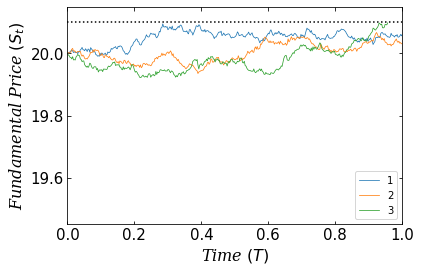

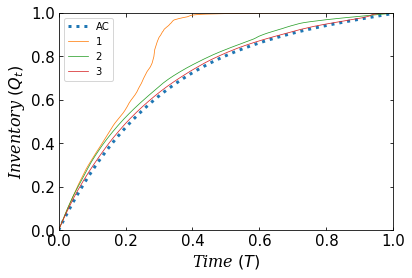

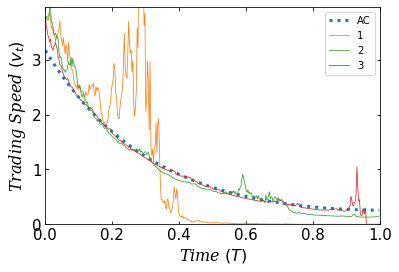

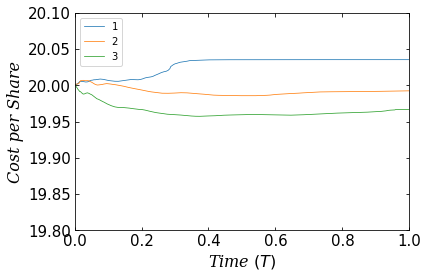

In [9]:
# Visualizing simulation for a few paths
PriceLimitSim_helpers.PlotPricePathMap(T, t, F, Fmin, Fmax, S, idxfig, lw)
PriceLimitSim_helpers.PlotInvPathMap(t, Q_AC, Q, idxfig, lw)
PriceLimitSim_helpers.PlotTradeSpeedPathMap(T, t, nu_AC, nu, idxfig, lw)
PriceLimitSim_helpers.PlotCostPathMap(t, X, Q, F0, Fmax, idxfig, lw)

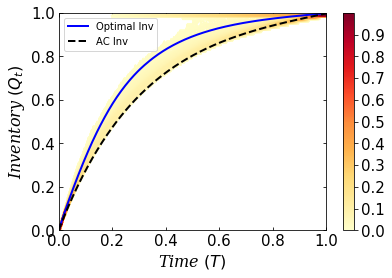

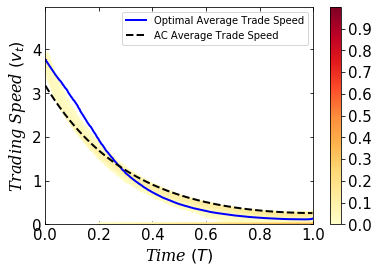

In [10]:
# Visualizing density plot of all simulations
PriceLimitSim_helpers.PlotInvHeatMap(t, Q, Q_AC, lower_cutoff, Nsims)
PriceLimitSim_helpers.PlotTradeSpeedHeatMap(t, nu, nu_AC, lower_cutoff, Nsims)


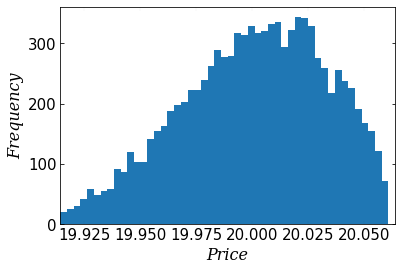

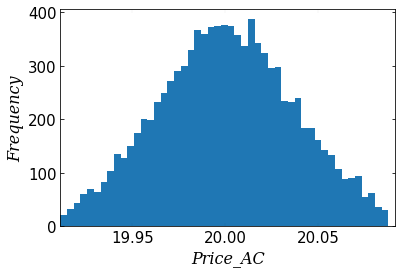

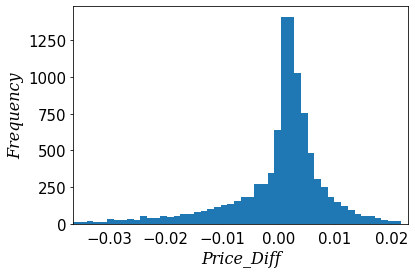

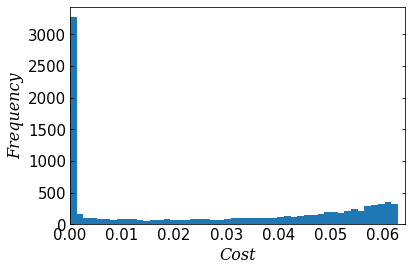

In [11]:
# Visualizing histograms of price related variables
PriceLimitSim_helpers.PlotPriceHist(X, Q)
PriceLimitSim_helpers.PlotPriceACHist(X_AC, Q_AC)
PriceLimitSim_helpers.PlotPriceDifHist(X, X_AC)
PriceLimitSim_helpers.PlotIHist(I)